<a href="https://colab.research.google.com/github/FrancescoCarrabino/depthOBJ/blob/main/DepthOBJ_Visualizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VISUALIZER notebook

In [ ]:
!pip install torch torchvision
import os
import sys
import torch
if torch.__version__=='1.6.0+cu101' and sys.platform.startswith('linux'):
    !pip install pytorch3d
else:
    need_pytorch3d=False
    try:
        import pytorch3d
    except ModuleNotFoundError:
        need_pytorch3d=True
    if need_pytorch3d:
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Datasets'

/content/drive/MyDrive/Datasets


In [ ]:
!unzip depthOBJ.zip -d '/content'

Output streaming troncato alle ultime 5000 righe.
  inflating: /content/content/drive/MyDrive/Datasets/depthOBJ/depthOBJ/Images/printer/6-printer (40).png  
  inflating: /content/content/drive/MyDrive/Datasets/depthOBJ/depthOBJ/Images/printer/6-printer (5).png  
  inflating: /content/content/drive/MyDrive/Datasets/depthOBJ/depthOBJ/Images/printer/6-printer (7).png  
  inflating: /content/content/drive/MyDrive/Datasets/depthOBJ/depthOBJ/Images/printer/6-printer (6).png  
  inflating: /content/content/drive/MyDrive/Datasets/depthOBJ/depthOBJ/Images/printer/6-printer (8).png  
  inflating: /content/content/drive/MyDrive/Datasets/depthOBJ/depthOBJ/Images/printer/6-printer (9).png  
  inflating: /content/content/drive/MyDrive/Datasets/depthOBJ/depthOBJ/Images/printer/7-printer (1).png  
  inflating: /content/content/drive/MyDrive/Datasets/depthOBJ/depthOBJ/Images/printer/7-printer (10).png  
  inflating: /content/content/drive/MyDrive/Datasets/depthOBJ/depthOBJ/Images/printer/7-printer (11)

In [ ]:
# directories of DepthOBJ
data_dir = '/content/content/drive/MyDrive/Datasets/depthOBJ/depthOBJ'
images_path = data_dir + '/Images/'
models_path = data_dir + '/Models/'

In [ ]:
demo_path = '/content/drive/MyDrive/Datasets/depthOBJ/Demo'

In [ ]:
# create the data generator to handle images from folders
datagen = ImageDataGenerator()

In [ ]:
# load the pretrained model
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/Trained Models/inception_resnet_v2_TL.h5")

In [ ]:
# generate the data from the Demo folder
demo_image_gen = datagen.flow_from_directory(demo_path, target_size=(256, 256), color_mode='rgb', batch_size=1, class_mode=None, shuffle=False)

# generate data for classes indeces from the Images directory
images_image_gen = datagen.flow_from_directory(images_path, target_size=(256, 256), color_mode='rgb', batch_size=32, class_mode='categorical', shuffle=True)

Found 3 images belonging to 3 classes.
Found 19440 images belonging to 54 classes.


In [ ]:
# set the steps for the predictions and reset the datagen to avoid bugs
TEST_STEPS = demo_image_gen.n//demo_image_gen.batch_size
demo_image_gen.reset()
pred = model.predict(demo_image_gen, steps=TEST_STEPS, verbose=1)

3/3 [==============================] - 0s 98ms/step


In [ ]:
import numpy as np


In [ ]:
# returns the max value on the probabilities of the predictions
predicted_class_indices=np.argmax(pred,axis=1)

In [ ]:
# visualize the indeces of the predictions
predicted_class_indices

array([14, 43, 45])

In [ ]:
# convert the indeces to names of the classes
labels = (images_image_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [ ]:
# visualize the predictions as names of classes
predictions

['car', 'rifle', 'sofa']

In [ ]:
# import the pytorch3D modules to load the mesh and visualize it in point-cloud form
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.structures import Meshes
from mpl_toolkits.mplot3d import Axes3D
from pytorch3d.ops import sample_points_from_meshes
import matplotlib.pyplot as plt 
import matplotlib as mpl

In [ ]:
# method for conversion and visualization of meshes into point-clouds, through the use of sample_points_from_meshes of Pytorch3D
def plot_pointcloud(mesh, title):
    points = sample_points_from_meshes(mesh, 100000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(10,10))
    ax = Axes3D(fig)
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(200, 150)
    plt.show()

/usr/local/lib/python3.6/dist-packages/pytorch3d/io/obj_io.py:457: UserWarning: Mtl file does not exist: /content/content/drive/MyDrive/Datasets/depthOBJ/depthOBJ/Models/model_normalized.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


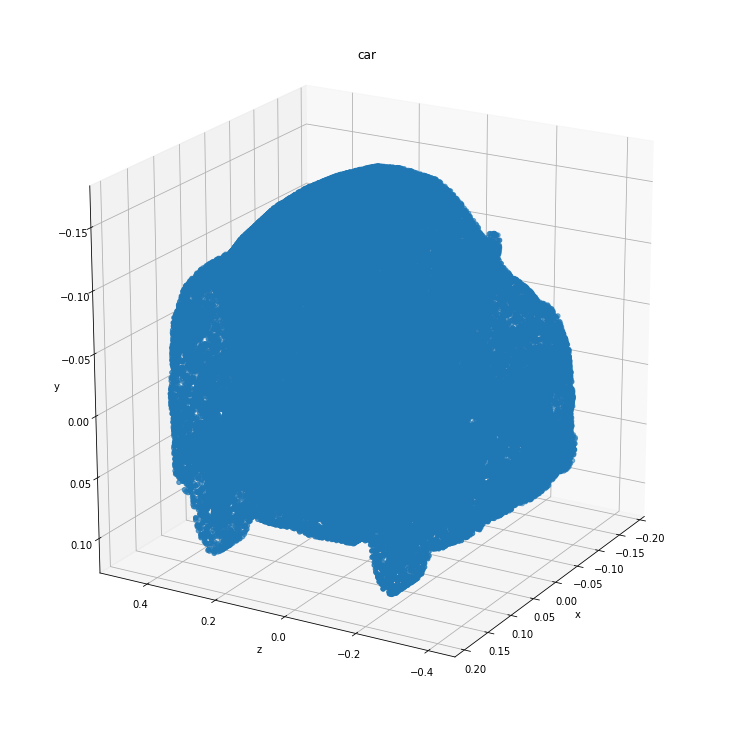

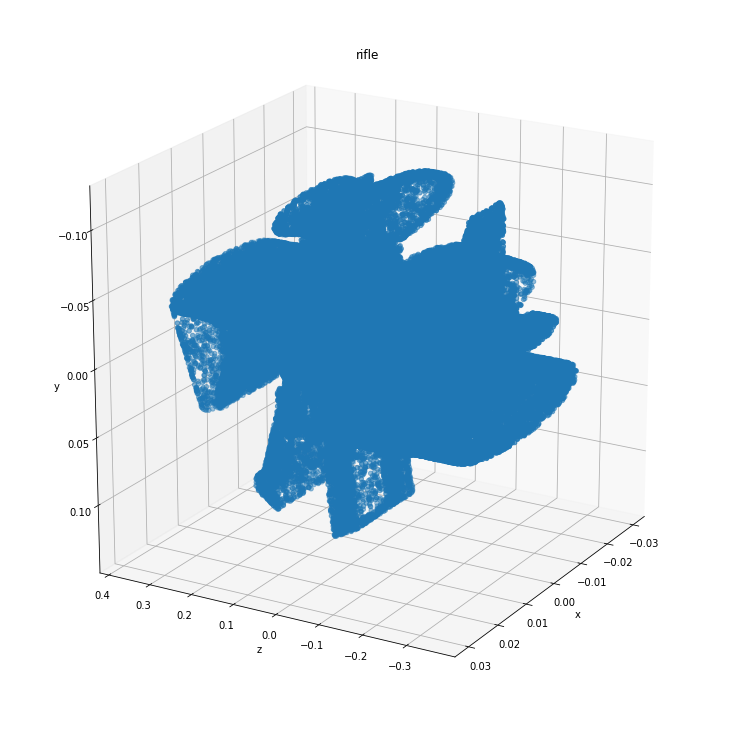

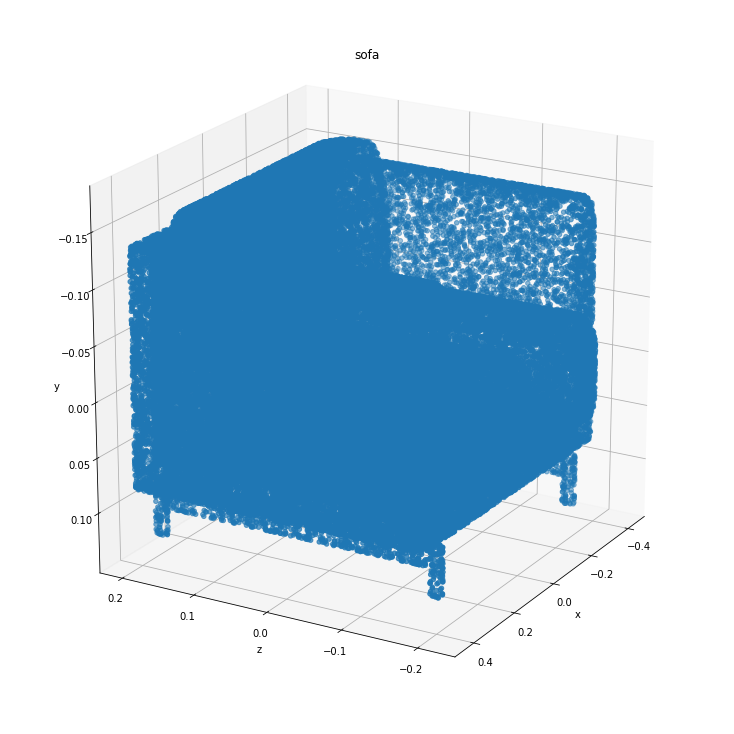

In [ ]:
# get the Meshes objects from the predictions and visualize a preview in the output
for p in predictions:
    trg_obj_path = models_path + p + '.obj'
    mesh = load_objs_as_meshes([trg_obj_path])
    trg_mesh = Meshes(verts= mesh.verts_list(), faces= mesh.faces_list())
    plot_pointcloud(trg_mesh, p)